### Model 2: XGBoost

__Date Features__: Integration of date-specific features to leverage chronological information.

__Normalization__: Not required in XGBoost, as it's an ensemble model of decision trees, which are scale-invariant.

__Hyperparameter Tuning__:
Exploring a wide range of major parameters increases the likelihood of identifying the optimal set of hyperparameters.

- `n_estimators`: Searching from 500 to 3000 decision trees.
- `learning_rate`: Varying from 0.01 to 0.1.
- `subsample`: Fraction of data used ranges from 50% to 100%.
- `gamma`: Set between 0 to 0.5.
- `min_child_weight`: Varies from 1 to 6 for each leaf node.
- `max_depth`: Tree depth ranging from 5 to 50.
- `lambda`: L2 regularization parameter from 0.25 to 1.
- `alpha`: L1 regularization parameter also from 0.25 to 1.


### Model 3: LightGBM

__Date Features__: Integration of date-specific features to leverage chronological information.

__Normalization__: Since `lightGBM` is an ensemble model of decision trees we do not need to normalize our data.

__Hyperparameter Tuning__: In `lightGBM` we explore the following hyperparamters:
- `num_leaves`: We vary the number of leaves in each tree from 5 to 500.
- `learning_rate`: The learning rate of the `lightGBM` model varies from 0.001 to 0.2
- `max_depth`: We vary the depth of the decision tree from 5 to 50
- `n_estimators`: The number of estimator trees varies from 500 to 3000
- `min_child_samples`: We vary the minimum child samples required in each tree from 0.001 to 0.2
- `reg_lambda`: The L2 regularization parameter varies from 0.1 to 1
- `reg_alpha`: The L2 regularization parameter varies from 0.1 to 1
- `colsample_bytree`: We vary the number of features taken in a tree from 0.5 (50% of all the features) to 1.

### Import Libraries & Data

In [1]:
# data manipulation 
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import plot_importance, plot_tree

# main module for evaluation
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# main modules for designing ML pipelines
from mlxtend.feature_selection import ColumnSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer 

# time-related feature engineering
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# others
import warnings
import pickle
import random
import gc
from itertools import product
import optuna

warnings.filterwarnings("ignore")
random.seed(42)
np.random.seed(42)

In [2]:
train_df = pd.read_pickle('processed_data/train_df.pkl')
train_df.head(5)

,date,family,sales,onpromotion,typeholiday,dcoilwtico,city,state,typestores,cluster,day_of_week,month,year
0,2013-01-01,AUTOMOTIVE,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
1,2013-01-01,BABY CARE,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
2,2013-01-01,BEAUTY,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
3,2013-01-01,BEVERAGES,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013
4,2013-01-01,BOOKS,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013


In [3]:
TARGET = ['sales']

TARGET_ENCODE_COLUMNS = ['family', 'cluster']

CATEGORY_COLUMNS = ['typeholiday','city', 'typestores', 'year']

TIME_COLUMNS = ['day_of_week', 'month']

COL_NAMES_ORIGINAL = ['family', 'typeholiday','onpromotion', 'dcoilwtico', 'city', 'typestores',
                    'cluster', 'year', 'day_of_week','month']

COL_NAMES_AFTER_TRANS=['target_trans__family', 'target_trans__cluster',
       'category_trans__typeholiday_Additional',
       'category_trans__typeholiday_Bridge',
       'category_trans__typeholiday_Event',
       'category_trans__typeholiday_Holiday',
       'category_trans__typeholiday_NDay',
       'category_trans__typeholiday_Transfer',
       'category_trans__city_Ambato', 'category_trans__city_Babahoyo',
       'category_trans__city_Cayambe', 'category_trans__city_Cuenca',
       'category_trans__city_Daule', 'category_trans__city_El Carmen',
       'category_trans__city_Esmeraldas', 'category_trans__city_Guaranda',
       'category_trans__city_Guayaquil', 'category_trans__city_Ibarra',
       'category_trans__city_Latacunga', 'category_trans__city_Libertad',
       'category_trans__city_Loja', 'category_trans__city_Machala',
       'category_trans__city_Manta', 'category_trans__city_Playas',
       'category_trans__city_Puyo', 'category_trans__city_Quevedo',
       'category_trans__city_Quito', 'category_trans__city_Riobamba',
       'category_trans__city_Salinas',
       'category_trans__city_Santo Domingo',
       'category_trans__typestores_A', 'category_trans__typestores_B',
       'category_trans__typestores_C', 'category_trans__typestores_D',
       'category_trans__typestores_E', 'category_trans__year_2013',
       'category_trans__year_2014', 'category_trans__year_2015',
       'category_trans__year_2016', 'category_trans__year_2017',
       'time_trans__day_of_week_sin__day_of_week',
       'time_trans__day_of_week_cos__day_of_week',
       'time_trans__month_sin__month', 'time_trans__month_cos__month',
       'time_trans__day_of_week_sin__day_of_week day_of_week_cos__day_of_week',
       'time_trans__day_of_week_sin__day_of_week month_sin__month',
       'time_trans__day_of_week_sin__day_of_week month_cos__month',
       'time_trans__day_of_week_cos__day_of_week month_sin__month',
       'time_trans__day_of_week_cos__day_of_week month_cos__month',
       'time_trans__month_sin__month month_cos__month',
       'remainder__onpromotion', 'remainder__dcoilwtico']

In [4]:
X = train_df[COL_NAMES_ORIGINAL]
y = train_df[TARGET]

### Build a Preprocess Pipeline


**1. Transforming Standard Date Representation**:
  - Standard Date represents days of the week as 0 (Sunday) to 6 (Saturday). This incorrectly implies a linear relationship between days, failing to capture their cyclical nature.
  - Transform via sine.cosine and added interaction using polynomial features.

**2. Target Encoding**:
  - Used for product categories and clusters.
  - This method involves replacing a categorical value with the mean of the target variable for that category. For instance, in the context of product categories, each category is replaced with the average size or another relevant metric from the training dataset.
  - To prevent data leakage, the encoding is fit on the training set and then applied to other datasets without refitting.

**3. One-Hot Encoding**:
  - Creates binary columns for categories such as holiday type.
  - These models, being tree-based, can handle categorical data inherently. However, one-hot encoding is still used due to its ability to create explicit feature representations, making the model more interpretable and sometimes improving performance by handling categories with very few occurrences more effectively.


**4. Add Lag Features**:

In [5]:
# pipeline for target encoding category features
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
target_encoder = TargetEncoder()

In [6]:
# helper functions to be able to get feature names out of functional transformer 
def f_out(self,input_features):
    return input_features

# functions to transform time features with sine cosine transformation 
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi), feature_names_out=f_out)

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi), feature_names_out=f_out)

## time feat pipeline: to avoid jump between first and last value of periodic range
## (1) sine/cosine transformation from ordinal features to trigonometric features
## (2) polynomial transformation to captrue linear interactions between time features
time_feat = make_pipeline(
                ColumnTransformer([
                            ("day_of_week_sin", sin_transformer(7), ["day_of_week"]),
                            ("day_of_week_cos", cos_transformer(7), ["day_of_week"]),
                            ("month_sin", sin_transformer(12), ["month"]),
                            ("month_cos", cos_transformer(12), ["month"])
                            ],remainder='drop'),
                PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))

In [7]:
# building the pipeline to perform feature engineering
preprocess_pipe = Pipeline(steps=[
    ('encoder', ColumnTransformer(
                    transformers=[
                        ("target_trans", target_encoder, TARGET_ENCODE_COLUMNS),
                        ("category_trans", one_hot_encoder, CATEGORY_COLUMNS),
                        ("time_trans",time_feat,TIME_COLUMNS),
                                ],
                                remainder="passthrough", verbose_feature_names_out=True
                            )),
    ("pandarizer2", FunctionTransformer(lambda x: pd.DataFrame(x, columns = COL_NAMES_AFTER_TRANS)))
                            ],verbose = True)

### Train-Validation Split

In [8]:
train_df['date'].max()

Timestamp('2017-08-15 00:00:00')

In [9]:
train_end_date = '2017-06-30'
val_start_date = '2017-07-01'
val_end_date = '2017-08-15'

In [10]:
train_df.set_index('date', inplace = True)
X.index = train_df.index
y.index = train_df.index

In [11]:
def train_test_split(df, train_end_date, val_start_date, val_end_date):
    
    # Split Dataset
    train_data = df[:train_end_date]
    validation_data = df[val_start_date:val_end_date]
    
    return train_data, validation_data

In [17]:
# Prepare the training and validation sets
X_train, X_val = train_test_split(X, train_end_date, val_start_date, val_end_date)
y_train, y_val = train_test_split(y, train_end_date, val_start_date, val_end_date)

In [18]:
preprocess_pipe.fit(X_train[COL_NAMES_ORIGINAL], y_train)

[Pipeline] ........... (step 1 of 2) Processing encoder, total=   4.5s
[Pipeline] ....... (step 2 of 2) Processing pandarizer2, total=   0.0s


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_trans',
                                                  TargetEncoder(),
                                                  ['family', 'cluster']),
                                                 ('category_trans',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['typeholiday', 'city',
                                                   'typestores', 'year']),
                                                 ('time_trans',
                                                  Pipeline(steps=[('columntransformer',
                                                                   ColumnTransformer(transformers=[('day_of_...
                                                                                                    FunctionTransformer(feature_names_out=<function f_out at 0x000001BB9602A160>,
                                                                                                                        func=<function cos_transformer.<locals>.<lambda> at 0x000001BB9602A660>),
                                                                                                    ['month'])])),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['day_of_week', 'month'])])),
                ('pandarizer2',
                 FunctionTransformer(func=<function <lambda> at 0x000001BB9602A2A0>))],
         verbose=True)

In [19]:
X_train = preprocess_pipe.transform(X_train[COL_NAMES_ORIGINAL])
X_val = preprocess_pipe.transform(X_val[COL_NAMES_ORIGINAL])

### Feature Importance

In [36]:
# early stopping call back to avoid xgboost overfitting 
early_stop = xgb.callback.EarlyStopping(rounds = 10, 
                                        metric_name = 'rmse', 
                                        maximize = False,
                                        save_best = True)

In [37]:
# training xgboost model
xgboost_base=XGBRegressor(random_state=42,verbosity=0, n_jobs = -1, reg_lambda=0.005, 
                         learning_rate=0.01, device='gpu',
                          n_estimators=5000, objective='reg:squarederror',
                        callbacks=[early_stop])
xgboost_base.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False)

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x000001D133265AC0>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

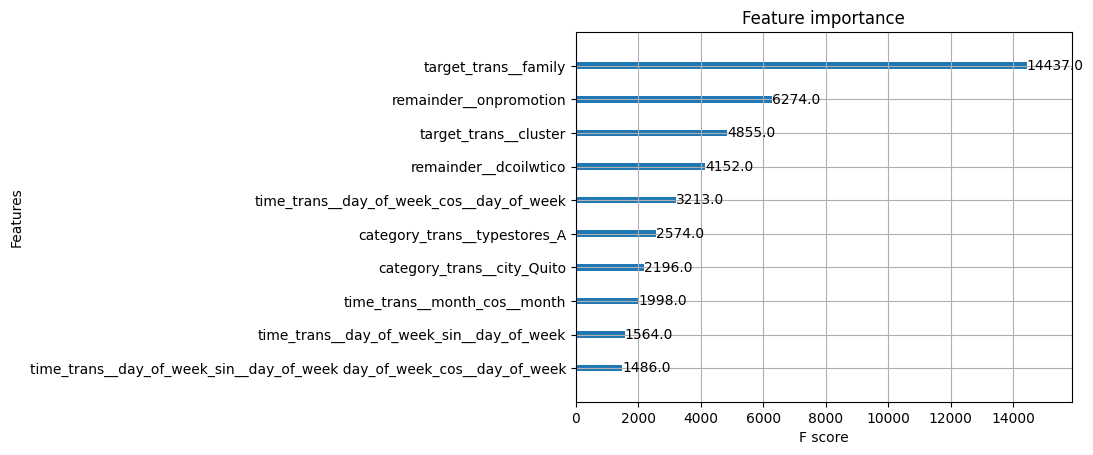

In [38]:
# ploting feature importances
_ = plot_importance(xgboost_base,max_num_features = 10)

### Hyperparameter Tuning



In [42]:
def objective(trial, X_train, y_train, X_val, y_val, name='xgb'):

    params = param = {
        'tree_method':'gpu_hist',  
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'eta': trial.suggest_float('eta', 1e-5, 0.1),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical( 
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.009,0.01,0.012,0.016, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300,500,1000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
        'random_state':10
        }

    model =  XGBRegressor(**params)
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=50,verbose=False)

    predictions_train = [a if a>0 else 0 for a in model.predict(X_train)]
    predictions_val  = [a if a>0 else 0 for a in model.predict(X_val)]           
    
    train_score = np.round(mean_squared_log_error(y_train, predictions_train), 5)
    test_score = np.round(mean_squared_log_error(y_val, predictions_val), 5)
    train_score = np.sqrt(train_score)
    test_score = np.sqrt(test_score)
                  
    print(f'TRAIN RMSLE : {train_score} || TEST RMSLE : {test_score}')
                  
    return test_score

In [43]:
# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)

# Best hyperparameters
print(study.best_params)

[I 2024-01-06 09:30:37,061] A new study created in memory with name: no-name-fe31b912-5573-4a6f-98bf-6b1e2f5d785e
[I 2024-01-06 09:32:03,937] Trial 0 finished with value: 0.97306731524597 and parameters: {'lambda': 0.021139977347579934, 'alpha': 0.002496560094196592, 'eta': 0.07046715033128446, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 213}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 1.3030579419196984 || TEST RMSLE : 0.97306731524597


[I 2024-01-06 09:32:37,904] Trial 1 finished with value: 2.105870366380609 and parameters: {'lambda': 0.015440297217742456, 'alpha': 4.196673270867994, 'eta': 0.01060684925506165, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 199}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 2.7353592085866896 || TEST RMSLE : 2.105870366380609


[I 2024-01-06 09:33:13,376] Trial 2 finished with value: 2.384738979427308 and parameters: {'lambda': 0.002096362386949793, 'alpha': 0.01664320359567732, 'eta': 0.00852965310993996, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 150, 'max_depth': 13, 'min_child_weight': 58}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 3.0044184129378517 || TEST RMSLE : 2.384738979427308


[I 2024-01-06 09:34:38,983] Trial 3 finished with value: 1.5276354277117299 and parameters: {'lambda': 9.023885891208458, 'alpha': 0.6347780633801201, 'eta': 0.0004109864461965835, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 17, 'min_child_weight': 79}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 2.0451356923197053 || TEST RMSLE : 1.5276354277117299


[I 2024-01-06 09:35:10,680] Trial 4 finished with value: 1.2145863493387368 and parameters: {'lambda': 0.02347616247012553, 'alpha': 0.004711336214241414, 'eta': 0.08434136043824347, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 250}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 1.8481450159551873 || TEST RMSLE : 1.2145863493387368


[I 2024-01-06 09:35:59,232] Trial 5 finished with value: 1.3936642350293702 and parameters: {'lambda': 1.2347475635493264, 'alpha': 0.007820517516755, 'eta': 0.06654823418638965, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 66}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 1.735381802370879 || TEST RMSLE : 1.3936642350293702


[I 2024-01-06 09:36:59,957] Trial 6 finished with value: 1.3870436186364148 and parameters: {'lambda': 0.11624075702580243, 'alpha': 1.73940927291919, 'eta': 0.0865584683111688, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 300, 'max_depth': 13, 'min_child_weight': 31}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 1.8650844484902018 || TEST RMSLE : 1.3870436186364148


[I 2024-01-06 09:37:24,974] Trial 7 finished with value: 1.4044109085306906 and parameters: {'lambda': 1.236940248249391, 'alpha': 0.0030715638666301416, 'eta': 0.02808477345213231, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 4, 'min_child_weight': 283}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 1.9767877984245046 || TEST RMSLE : 1.4044109085306906


[I 2024-01-06 09:37:56,760] Trial 8 finished with value: 1.1434509171800948 and parameters: {'lambda': 0.26394076329099936, 'alpha': 4.806409200833016, 'eta': 0.09456567936668088, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 46}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 1.668849903376574 || TEST RMSLE : 1.1434509171800948


[I 2024-01-06 09:38:26,642] Trial 9 finished with value: 1.9368866771187208 and parameters: {'lambda': 0.04514979516234375, 'alpha': 0.32368982540304453, 'eta': 0.07155182579006836, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 207}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 2.5174193135034137 || TEST RMSLE : 1.9368866771187208


[I 2024-01-06 09:39:25,475] Trial 10 finished with value: 1.4157612793122998 and parameters: {'lambda': 0.0017875474061058785, 'alpha': 0.0537045559366739, 'eta': 0.047119292369466145, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 163}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 1.7041038700736526 || TEST RMSLE : 1.4157612793122998


[I 2024-01-06 09:39:56,486] Trial 11 finished with value: 1.4885059623662917 and parameters: {'lambda': 0.34095387941669225, 'alpha': 0.08681782685429891, 'eta': 0.09789233603194603, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 126}. Best is trial 0 with value: 0.97306731524597.


TRAIN RMSLE : 1.9294299676329276 || TEST RMSLE : 1.4885059623662917


[I 2024-01-06 09:40:45,366] Trial 12 finished with value: 0.842531898505926 and parameters: {'lambda': 0.0076989187393306105, 'alpha': 0.0010522989434772285, 'eta': 0.05844334492928936, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 11, 'min_child_weight': 126}. Best is trial 12 with value: 0.842531898505926.


TRAIN RMSLE : 1.27849520922059 || TEST RMSLE : 0.842531898505926


[I 2024-01-06 09:41:28,328] Trial 13 finished with value: 0.983671693198498 and parameters: {'lambda': 0.0058368301468643465, 'alpha': 0.0011199775132303908, 'eta': 0.05174833711031827, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 11, 'min_child_weight': 125}. Best is trial 12 with value: 0.842531898505926.


TRAIN RMSLE : 1.3748563561332507 || TEST RMSLE : 0.983671693198498


[I 2024-01-06 09:42:35,071] Trial 14 finished with value: 0.8006872048434395 and parameters: {'lambda': 0.010379567864562813, 'alpha': 0.00118840235381704, 'eta': 0.052722138063083124, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 186}. Best is trial 14 with value: 0.8006872048434395.


TRAIN RMSLE : 1.2409673645990857 || TEST RMSLE : 0.8006872048434395


[I 2024-01-06 09:43:01,475] Trial 15 finished with value: 1.8488023150136956 and parameters: {'lambda': 0.0065462765930977525, 'alpha': 0.0010068250629216408, 'eta': 0.04469692325176845, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 150, 'max_depth': 11, 'min_child_weight': 146}. Best is trial 14 with value: 0.8006872048434395.


TRAIN RMSLE : 2.4332591312887333 || TEST RMSLE : 1.8488023150136956


[I 2024-01-06 09:45:49,317] Trial 16 finished with value: 0.7403985413275744 and parameters: {'lambda': 0.005152375904292122, 'alpha': 0.02377719983124111, 'eta': 0.03248565402755877, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 94}. Best is trial 16 with value: 0.7403985413275744.


TRAIN RMSLE : 1.133988536097257 || TEST RMSLE : 0.7403985413275744


[I 2024-01-06 09:50:25,269] Trial 17 finished with value: 1.2799140596149414 and parameters: {'lambda': 0.0016046178616332804, 'alpha': 0.021727069734195942, 'eta': 0.03364685880437113, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 8}. Best is trial 16 with value: 0.7403985413275744.


TRAIN RMSLE : 1.764735107601138 || TEST RMSLE : 1.2799140596149414


[I 2024-01-06 09:54:15,011] Trial 18 finished with value: 1.0054750121211367 and parameters: {'lambda': 0.05500585233210901, 'alpha': 0.029790522936803714, 'eta': 0.03241905749036395, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 175}. Best is trial 16 with value: 0.7403985413275744.


TRAIN RMSLE : 1.3525494445675545 || TEST RMSLE : 1.0054750121211367


[I 2024-01-06 09:55:40,684] Trial 19 finished with value: 1.4671332591145223 and parameters: {'lambda': 0.0045777381936909205, 'alpha': 0.24803229272639907, 'eta': 0.019181357880471556, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 98}. Best is trial 16 with value: 0.7403985413275744.


TRAIN RMSLE : 1.652019975666154 || TEST RMSLE : 1.4671332591145223


[I 2024-01-06 09:56:35,376] Trial 20 finished with value: 1.2464509617309458 and parameters: {'lambda': 0.012739125823030313, 'alpha': 0.01480339236590088, 'eta': 0.039353455881324224, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 249}. Best is trial 16 with value: 0.7403985413275744.


TRAIN RMSLE : 1.76828447937542 || TEST RMSLE : 1.2464509617309458


[I 2024-01-06 09:57:25,415] Trial 21 finished with value: 0.9612855975203207 and parameters: {'lambda': 0.003937519209997551, 'alpha': 0.00248208502243675, 'eta': 0.061456289609503466, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 104}. Best is trial 16 with value: 0.7403985413275744.


TRAIN RMSLE : 1.489278348731358 || TEST RMSLE : 0.9612855975203207
TRAIN RMSLE : 1.3720787149431333 || TEST RMSLE : 0.9672021505352436


[I 2024-01-06 10:00:23,356] Trial 22 finished with value: 0.9672021505352436 and parameters: {'lambda': 0.0010965738758781836, 'alpha': 0.006905226430745995, 'eta': 0.05788490525584511, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.009, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 135}. Best is trial 16 with value: 0.7403985413275744.
[I 2024-01-06 10:01:19,285] Trial 23 finished with value: 0.769798674979374 and parameters: {'lambda': 0.009428245694437733, 'alpha': 0.0015463536069488296, 'eta': 0.0532387806315832, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 171}. Best is trial 16 with value: 0.7403985413275744.


TRAIN RMSLE : 1.2341758383633996 || TEST RMSLE : 0.769798674979374


[I 2024-01-06 10:02:26,330] Trial 24 finished with value: 0.7907844206861944 and parameters: {'lambda': 0.06185257961377601, 'alpha': 0.00903318890988204, 'eta': 0.022736425860486482, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 176}. Best is trial 16 with value: 0.7403985413275744.


TRAIN RMSLE : 1.2356415337791136 || TEST RMSLE : 0.7907844206861944


[I 2024-01-06 10:04:27,770] Trial 25 finished with value: 0.7299657526213131 and parameters: {'lambda': 0.04764282646491828, 'alpha': 0.01175260823636492, 'eta': 0.021567350323225105, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 234}. Best is trial 25 with value: 0.7299657526213131.


TRAIN RMSLE : 1.1422083872919162 || TEST RMSLE : 0.7299657526213131


[I 2024-01-06 10:05:50,950] Trial 26 finished with value: 0.7340027247905828 and parameters: {'lambda': 0.15182988413987902, 'alpha': 0.07996780145053656, 'eta': 0.0390100828080522, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 233}. Best is trial 25 with value: 0.7299657526213131.


TRAIN RMSLE : 1.1493780927092703 || TEST RMSLE : 0.7340027247905828


[I 2024-01-06 10:08:11,961] Trial 27 finished with value: 1.1010903686800644 and parameters: {'lambda': 0.12507387981597615, 'alpha': 0.13310587229742232, 'eta': 0.0176209302571826, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 294}. Best is trial 25 with value: 0.7299657526213131.


TRAIN RMSLE : 1.4030039201655853 || TEST RMSLE : 1.1010903686800644


[I 2024-01-06 10:08:58,147] Trial 28 finished with value: 2.027981755341995 and parameters: {'lambda': 0.5317969525322027, 'alpha': 0.04242308435199099, 'eta': 0.03564814444962369, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 150, 'max_depth': 17, 'min_child_weight': 231}. Best is trial 25 with value: 0.7299657526213131.


TRAIN RMSLE : 2.4994959491865556 || TEST RMSLE : 2.027981755341995


[I 2024-01-06 10:10:00,828] Trial 29 finished with value: 1.3563185466548777 and parameters: {'lambda': 0.03393275866608016, 'alpha': 0.11433856894488598, 'eta': 0.025193000785836903, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 17, 'min_child_weight': 267}. Best is trial 25 with value: 0.7299657526213131.


TRAIN RMSLE : 1.7794662120984484 || TEST RMSLE : 1.3563185466548777


[I 2024-01-06 10:12:11,446] Trial 30 finished with value: 0.722225726487225 and parameters: {'lambda': 0.1582024480242145, 'alpha': 0.05507624249792045, 'eta': 0.04094899840240296, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 226}. Best is trial 30 with value: 0.722225726487225.


TRAIN RMSLE : 1.1414245485357322 || TEST RMSLE : 0.722225726487225


[I 2024-01-06 10:14:01,837] Trial 31 finished with value: 0.725596306495561 and parameters: {'lambda': 0.16972882294985794, 'alpha': 0.05986835883912451, 'eta': 0.04392051460285981, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 231}. Best is trial 30 with value: 0.722225726487225.


TRAIN RMSLE : 1.1396227445957718 || TEST RMSLE : 0.725596306495561


[I 2024-01-06 10:15:27,901] Trial 32 finished with value: 0.7265879162221183 and parameters: {'lambda': 0.20508963311449818, 'alpha': 0.06263381972321912, 'eta': 0.04370501714948046, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 223}. Best is trial 30 with value: 0.722225726487225.


TRAIN RMSLE : 1.1424359938307267 || TEST RMSLE : 0.7265879162221183


[I 2024-01-06 10:16:40,824] Trial 33 finished with value: 0.546726622728398 and parameters: {'lambda': 0.6202804948656677, 'alpha': 0.23108156417428702, 'eta': 0.04176761650765426, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 221}. Best is trial 33 with value: 0.546726622728398.


TRAIN RMSLE : 1.0061312041677268 || TEST RMSLE : 0.546726622728398


[I 2024-01-06 10:17:53,248] Trial 34 finished with value: 0.5383493289677252 and parameters: {'lambda': 1.0128210039315775, 'alpha': 0.7249260906864707, 'eta': 0.04398171564055497, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 208}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 0.9981132200306736 || TEST RMSLE : 0.5383493289677252


[I 2024-01-06 10:18:38,672] Trial 35 finished with value: 1.0107076728708455 and parameters: {'lambda': 0.879381295665915, 'alpha': 0.9502952832074426, 'eta': 0.04119364981377637, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 17, 'min_child_weight': 260}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.517705505030538 || TEST RMSLE : 1.0107076728708455


[I 2024-01-06 10:19:07,867] Trial 36 finished with value: 2.2894955776327675 and parameters: {'lambda': 3.1227444883723448, 'alpha': 0.23955714811126688, 'eta': 0.07213237724990083, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 150, 'max_depth': 13, 'min_child_weight': 196}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 2.912134955663971 || TEST RMSLE : 2.2894955776327675


[I 2024-01-06 10:20:15,383] Trial 37 finished with value: 0.7240994406847723 and parameters: {'lambda': 3.192978803931109, 'alpha': 0.5345797511517428, 'eta': 0.06492004427644214, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 210}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.2567816039392046 || TEST RMSLE : 0.7240994406847723


[I 2024-01-06 10:20:46,244] Trial 38 finished with value: 1.61319868584127 and parameters: {'lambda': 2.9970514424446915, 'alpha': 2.326683699008147, 'eta': 0.0796287669492832, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 203}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 2.256229155028363 || TEST RMSLE : 1.61319868584127


[I 2024-01-06 10:21:47,612] Trial 39 finished with value: 0.7070855676649044 and parameters: {'lambda': 8.324967047223371, 'alpha': 0.5396010415866362, 'eta': 0.06476261305526713, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 220}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.2789136014602394 || TEST RMSLE : 0.7070855676649044


[I 2024-01-06 10:22:55,219] Trial 40 finished with value: 0.7120463468061612 and parameters: {'lambda': 9.587272496016704, 'alpha': 1.024370111958819, 'eta': 0.07734259339119867, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 247}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.2607299472924405 || TEST RMSLE : 0.7120463468061612


[I 2024-01-06 10:24:00,805] Trial 41 finished with value: 0.6978036973246845 and parameters: {'lambda': 7.02015200041342, 'alpha': 1.110343218399325, 'eta': 0.07784067419990333, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 272}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.2621608455343558 || TEST RMSLE : 0.6978036973246845


[I 2024-01-06 10:25:07,528] Trial 42 finished with value: 0.705528170947128 and parameters: {'lambda': 7.926148887904726, 'alpha': 8.596889715777147, 'eta': 0.07652278095173602, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 276}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.2621053838725196 || TEST RMSLE : 0.705528170947128


[I 2024-01-06 10:26:12,737] Trial 43 finished with value: 0.7095702925010319 and parameters: {'lambda': 5.834392927940444, 'alpha': 9.3595835903841, 'eta': 0.08818611177147358, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 278}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.2624777225757293 || TEST RMSLE : 0.7095702925010319


[I 2024-01-06 10:26:43,508] Trial 44 finished with value: 1.6137874705177258 and parameters: {'lambda': 5.597973433882218, 'alpha': 3.2203526585214712, 'eta': 0.07593102948824783, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 300}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 2.259238809864951 || TEST RMSLE : 1.6137874705177258


[I 2024-01-06 10:27:49,573] Trial 45 finished with value: 0.7108093977994382 and parameters: {'lambda': 1.7942735092733841, 'alpha': 1.390716352346693, 'eta': 0.06549491832494367, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 271}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.2614119073482697 || TEST RMSLE : 0.7108093977994382


[I 2024-01-06 10:28:19,102] Trial 46 finished with value: 2.1106136548406957 and parameters: {'lambda': 5.843148061421489, 'alpha': 0.49430219839545914, 'eta': 0.06896079048095256, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 288}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 2.7644022862094437 || TEST RMSLE : 2.1106136548406957


[I 2024-01-06 10:29:06,757] Trial 47 finished with value: 1.2469522845722687 and parameters: {'lambda': 0.6754523438357345, 'alpha': 5.706723682013265, 'eta': 0.08331042594366636, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 257}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.7885776471822519 || TEST RMSLE : 1.2469522845722687


[I 2024-01-06 10:29:58,277] Trial 48 finished with value: 1.0652042057746487 and parameters: {'lambda': 1.8460941433312508, 'alpha': 0.3472020589976755, 'eta': 0.09453929821565445, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 190}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.6080485067310626 || TEST RMSLE : 1.0652042057746487


[I 2024-01-06 10:31:32,460] Trial 49 finished with value: 0.5805428494090682 and parameters: {'lambda': 4.3407296411990455, 'alpha': 0.16849946836064067, 'eta': 0.04832416613811499, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 241}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.090417351292614 || TEST RMSLE : 0.5805428494090682


[I 2024-01-06 10:32:02,669] Trial 50 finished with value: 2.475089897357266 and parameters: {'lambda': 1.8959617249516063, 'alpha': 0.17924691563918263, 'eta': 0.056934584318455314, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 150, 'max_depth': 13, 'min_child_weight': 242}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 3.109319861320157 || TEST RMSLE : 2.475089897357266


[I 2024-01-06 10:33:34,528] Trial 51 finished with value: 0.5853802183196832 and parameters: {'lambda': 4.524312466506177, 'alpha': 0.8149704523033621, 'eta': 0.04853985025291728, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 215}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0931148155614763 || TEST RMSLE : 0.5853802183196832


[I 2024-01-06 10:35:07,533] Trial 52 finished with value: 0.6009742090971958 and parameters: {'lambda': 3.8843582871344005, 'alpha': 0.7773761386559485, 'eta': 0.048601618992832406, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 277}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0938738501308092 || TEST RMSLE : 0.6009742090971958


[I 2024-01-06 10:36:47,070] Trial 53 finished with value: 0.5787054518492114 and parameters: {'lambda': 4.686983964837408, 'alpha': 0.9709899112959733, 'eta': 0.04897946003542702, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 261}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.083863460035442 || TEST RMSLE : 0.5787054518492114


[I 2024-01-06 10:38:27,439] Trial 54 finished with value: 0.6052189686386242 and parameters: {'lambda': 3.920150686035793, 'alpha': 0.7269078961906889, 'eta': 0.04888996286384404, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 261}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0788883167408942 || TEST RMSLE : 0.6052189686386242


[I 2024-01-06 10:39:15,739] Trial 55 finished with value: 1.866467251253019 and parameters: {'lambda': 1.2905395372425774, 'alpha': 1.9290295348961508, 'eta': 0.04787847303453274, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 13, 'min_child_weight': 241}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 2.414526868767461 || TEST RMSLE : 1.866467251253019


[I 2024-01-06 10:40:40,714] Trial 56 finished with value: 0.5772954183085122 and parameters: {'lambda': 0.38567749752953445, 'alpha': 0.3164401127587253, 'eta': 0.05455643432787671, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 214}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0874097663714448 || TEST RMSLE : 0.5772954183085122


[I 2024-01-06 10:42:05,885] Trial 57 finished with value: 0.571550522701187 and parameters: {'lambda': 0.33857074991860747, 'alpha': 0.37521049640253223, 'eta': 0.05352233014713502, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 208}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0788466063347468 || TEST RMSLE : 0.571550522701187


[I 2024-01-06 10:43:22,501] Trial 58 finished with value: 0.6809552114493287 and parameters: {'lambda': 0.3529998006020727, 'alpha': 0.17484851826207015, 'eta': 0.0545136136811191, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 160}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.1940896113776387 || TEST RMSLE : 0.6809552114493287


[I 2024-01-06 10:44:35,354] Trial 59 finished with value: 1.2980331274663217 and parameters: {'lambda': 0.44438427921727836, 'alpha': 0.3632696036426958, 'eta': 0.03641913684322552, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 186}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.7063293937572546 || TEST RMSLE : 1.2980331274663217


[I 2024-01-06 10:45:34,662] Trial 60 finished with value: 1.148324866925732 and parameters: {'lambda': 0.7928470683302533, 'alpha': 0.2515681277378859, 'eta': 0.060300655670177214, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 7, 'min_child_weight': 205}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.537019843723561 || TEST RMSLE : 1.148324866925732


[I 2024-01-06 10:47:00,240] Trial 61 finished with value: 0.5711917366349062 and parameters: {'lambda': 0.25282717539239546, 'alpha': 0.4059266646637451, 'eta': 0.05235380441709273, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 215}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.08880209404648 || TEST RMSLE : 0.5711917366349062


[I 2024-01-06 10:48:28,492] Trial 62 finished with value: 0.5615781334774351 and parameters: {'lambda': 0.08659640792663297, 'alpha': 0.3936421543785047, 'eta': 0.05427758191745524, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 215}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0727161786791508 || TEST RMSLE : 0.5615781334774351


[I 2024-01-06 10:49:55,996] Trial 63 finished with value: 0.5651017607475666 and parameters: {'lambda': 0.08707939949859796, 'alpha': 0.48740463382031624, 'eta': 0.05304349347076083, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 197}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0707987672760928 || TEST RMSLE : 0.5651017607475666


[I 2024-01-06 17:24:59,965] Trial 64 finished with value: 1.2513912257963133 and parameters: {'lambda': 0.07885942592617448, 'alpha': 0.4285104185781684, 'eta': 0.055556974426604955, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 196}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.54503721638024 || TEST RMSLE : 1.2513912257963133


[I 2024-01-06 17:25:58,132] Trial 65 finished with value: 1.9817921182606415 and parameters: {'lambda': 0.2518582133252778, 'alpha': 0.28627430367233647, 'eta': 0.06180730079449234, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 216}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 2.5893107190910865 || TEST RMSLE : 1.9817921182606415


[I 2024-01-06 17:28:35,785] Trial 66 finished with value: 1.0270053553901264 and parameters: {'lambda': 0.08600530450548535, 'alpha': 0.37095172603598164, 'eta': 0.05195936094222611, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 181}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.333859063019778 || TEST RMSLE : 1.0270053553901264


[I 2024-01-06 17:30:22,189] Trial 67 finished with value: 0.6786309748309459 and parameters: {'lambda': 0.3109444803281117, 'alpha': 1.4746821141547277, 'eta': 0.02853009154499501, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 165}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.1927279656317278 || TEST RMSLE : 0.6786309748309459


[I 2024-01-06 17:31:41,888] Trial 68 finished with value: 1.062426468043789 and parameters: {'lambda': 0.023932647297037073, 'alpha': 0.6220874209448399, 'eta': 0.044847392945036035, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 154}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.6063374489813775 || TEST RMSLE : 1.062426468043789


[I 2024-01-06 17:32:14,143] Trial 69 finished with value: 2.3559541591465654 and parameters: {'lambda': 0.4904091971407942, 'alpha': 0.09885331116249339, 'eta': 0.05872517720487292, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 150, 'max_depth': 4, 'min_child_weight': 196}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 3.0537927238108353 || TEST RMSLE : 2.3559541591465654


[I 2024-01-06 17:33:15,679] Trial 70 finished with value: 1.3771492293865615 and parameters: {'lambda': 0.234021025138193, 'alpha': 0.21783761823536424, 'eta': 0.05208232814467098, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 210}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.8901772403666275 || TEST RMSLE : 1.3771492293865615


[I 2024-01-06 17:35:21,958] Trial 71 finished with value: 0.5800172411230549 and parameters: {'lambda': 0.11345611336436058, 'alpha': 0.4226691270570012, 'eta': 0.04538026646831772, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 222}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.075141851106169 || TEST RMSLE : 0.5800172411230549


[I 2024-01-06 17:36:58,506] Trial 72 finished with value: 0.6267934268959751 and parameters: {'lambda': 0.38230675340369963, 'alpha': 0.6613287007428494, 'eta': 0.05474959885230098, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 190}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.1373917530912556 || TEST RMSLE : 0.6267934268959751


[I 2024-01-06 17:38:19,943] Trial 73 finished with value: 0.5898389610732746 and parameters: {'lambda': 0.5678055432031072, 'alpha': 0.13322884496727017, 'eta': 0.04132090669072964, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 203}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.104590421830644 || TEST RMSLE : 0.5898389610732746


[I 2024-01-06 17:40:19,132] Trial 74 finished with value: 0.581343272086295 and parameters: {'lambda': 0.9573354887008595, 'alpha': 0.2990874739097436, 'eta': 0.03846468088600076, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 229}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0827511256055105 || TEST RMSLE : 0.581343272086295


[I 2024-01-06 17:42:56,276] Trial 75 finished with value: 1.250091996614649 and parameters: {'lambda': 0.1744918612000651, 'alpha': 1.2680163612508129, 'eta': 0.050427724138610054, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 215}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.547252403455881 || TEST RMSLE : 1.250091996614649


[I 2024-01-06 17:44:06,141] Trial 76 finished with value: 0.6218038275855176 and parameters: {'lambda': 0.06185393267536286, 'alpha': 0.4962106212023089, 'eta': 0.030291091237689607, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 140}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.1311189150571217 || TEST RMSLE : 0.6218038275855176


[I 2024-01-06 17:45:13,103] Trial 77 finished with value: 1.4438178555482684 and parameters: {'lambda': 0.2950837174664243, 'alpha': 2.1665629109939886, 'eta': 0.04597200004875082, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 13, 'min_child_weight': 252}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 2.0199950494988843 || TEST RMSLE : 1.4438178555482684


[I 2024-01-06 17:49:00,860] Trial 78 finished with value: 0.8090982635007938 and parameters: {'lambda': 1.1272383998830942, 'alpha': 0.20502485825585545, 'eta': 0.0620735163332631, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 173}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.1900714264278425 || TEST RMSLE : 0.8090982635007938


[I 2024-01-06 17:50:14,750] Trial 79 finished with value: 0.5753433757331355 and parameters: {'lambda': 0.12659859422997344, 'alpha': 0.9564876491424974, 'eta': 0.042589431883442, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 235}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.077942484551008 || TEST RMSLE : 0.5753433757331355


[I 2024-01-06 17:51:00,917] Trial 80 finished with value: 1.0355433356455923 and parameters: {'lambda': 0.12346772407043705, 'alpha': 0.1421365409642626, 'eta': 0.04289170220918226, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 237}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.618505483463062 || TEST RMSLE : 1.0355433356455923


[I 2024-01-06 17:52:20,129] Trial 81 finished with value: 0.5586143571373725 and parameters: {'lambda': 0.04101060661937289, 'alpha': 0.6227876308140678, 'eta': 0.051002898011795965, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 225}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.062835829279386 || TEST RMSLE : 0.5586143571373725


[I 2024-01-06 17:53:34,630] Trial 82 finished with value: 0.5832409450647305 and parameters: {'lambda': 0.018899836871735548, 'alpha': 0.5601405710775011, 'eta': 0.006920182901123624, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 208}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.071148915884248 || TEST RMSLE : 0.5832409450647305


[I 2024-01-06 17:54:47,925] Trial 83 finished with value: 0.5746042116100438 and parameters: {'lambda': 0.03403201925786231, 'alpha': 0.3050269003015248, 'eta': 0.035559519361508675, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 13, 'min_child_weight': 224}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0842186126423028 || TEST RMSLE : 0.5746042116100438


[I 2024-01-06 17:56:30,485] Trial 84 finished with value: 0.5417748609893228 and parameters: {'lambda': 0.07494013607794574, 'alpha': 0.43765936878215705, 'eta': 0.039153566730737846, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 226}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.004718866151124 || TEST RMSLE : 0.5417748609893228


[I 2024-01-06 17:58:06,956] Trial 85 finished with value: 0.5646326239246188 and parameters: {'lambda': 0.030292895470011648, 'alpha': 0.4085055903753706, 'eta': 0.036357547632410114, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 226}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.029436739192846 || TEST RMSLE : 0.5646326239246188


[I 2024-01-06 18:00:35,405] Trial 86 finished with value: 0.9716223546213827 and parameters: {'lambda': 0.03895007984348516, 'alpha': 0.416278194274019, 'eta': 0.03281332672628525, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 202}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.2929771846401623 || TEST RMSLE : 0.9716223546213827


[I 2024-01-06 18:01:42,730] Trial 87 finished with value: 1.426499211356249 and parameters: {'lambda': 0.02633676975458844, 'alpha': 0.6624999394820591, 'eta': 0.03846290392927642, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 150, 'max_depth': 17, 'min_child_weight': 221}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.9676229313565137 || TEST RMSLE : 1.426499211356249


[I 2024-01-06 18:03:15,927] Trial 88 finished with value: 0.599849981245311 and parameters: {'lambda': 0.07017604717257386, 'alpha': 0.24744168114784693, 'eta': 0.058191636910428855, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 246}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.068442792104472 || TEST RMSLE : 0.599849981245311


[I 2024-01-06 18:06:17,526] Trial 89 finished with value: 1.060160365227827 and parameters: {'lambda': 0.015608591793823953, 'alpha': 0.4678958132742389, 'eta': 0.051553190804881306, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 181}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.3694780027441114 || TEST RMSLE : 1.060160365227827


[I 2024-01-06 18:07:58,557] Trial 90 finished with value: 0.7371566997592846 and parameters: {'lambda': 0.051322048917622015, 'alpha': 1.6460063003502032, 'eta': 0.025421895482375577, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 229}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.188326554445368 || TEST RMSLE : 0.7371566997592846


[I 2024-01-06 18:09:41,034] Trial 91 finished with value: 0.5695963483029013 and parameters: {'lambda': 0.029355296900693044, 'alpha': 0.336403414095188, 'eta': 0.03557573609437346, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 226}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0290772565750348 || TEST RMSLE : 0.5695963483029013


[I 2024-01-06 18:11:18,570] Trial 92 finished with value: 0.5444630382312466 and parameters: {'lambda': 0.02933360076462536, 'alpha': 0.7993806739110209, 'eta': 0.037363728981603464, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 252}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0112764211628786 || TEST RMSLE : 0.5444630382312466


[I 2024-01-06 18:13:00,670] Trial 93 finished with value: 0.5539855593785816 and parameters: {'lambda': 0.04048637367935121, 'alpha': 0.8227082289879623, 'eta': 0.034730828634413326, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 253}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0100940550265602 || TEST RMSLE : 0.5539855593785816


[I 2024-01-06 18:14:40,963] Trial 94 finished with value: 0.5439577189451401 and parameters: {'lambda': 0.02996314137754713, 'alpha': 0.7872095798040225, 'eta': 0.03463331628130328, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 255}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0126203632161463 || TEST RMSLE : 0.5439577189451401


[I 2024-01-06 18:16:26,311] Trial 95 finished with value: 0.5425126726630448 and parameters: {'lambda': 0.0433325632757835, 'alpha': 1.1578058693037807, 'eta': 0.029064719784225302, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 251}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.0019231507456048 || TEST RMSLE : 0.5425126726630448


[I 2024-01-06 18:18:35,677] Trial 96 finished with value: 1.2742644937374659 and parameters: {'lambda': 0.04005324245548039, 'alpha': 1.170677621608528, 'eta': 0.027535937644132296, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 256}. Best is trial 34 with value: 0.5383493289677252.


TRAIN RMSLE : 1.535613883761149 || TEST RMSLE : 1.2742644937374659


[I 2024-01-06 18:28:52,728] Trial 97 finished with value: 0.536861248368701 and parameters: {'lambda': 0.02188854135712765, 'alpha': 3.003404102231338, 'eta': 0.03095192851626769, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 251}. Best is trial 97 with value: 0.536861248368701.


TRAIN RMSLE : 0.9962630174808257 || TEST RMSLE : 0.536861248368701


[I 2024-01-06 18:30:34,176] Trial 98 finished with value: 0.5482973645750999 and parameters: {'lambda': 0.012161275183237662, 'alpha': 3.034200549655049, 'eta': 0.03037396942239324, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 286}. Best is trial 97 with value: 0.536861248368701.


TRAIN RMSLE : 1.00637965003273 || TEST RMSLE : 0.5482973645750999


[I 2024-01-06 18:32:30,328] Trial 99 finished with value: 0.8675252157718529 and parameters: {'lambda': 0.013350965357793244, 'alpha': 3.084419337083244, 'eta': 0.030628714411212694, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 289}. Best is trial 97 with value: 0.536861248368701.


TRAIN RMSLE : 1.2501559902668147 || TEST RMSLE : 0.8675252157718529
{'lambda': 0.02188854135712765, 'alpha': 3.003404102231338, 'eta': 0.03095192851626769, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 251}


In [26]:
def objective(trial, X_train, y_train, X_val, y_val, name='lgb'):
    if name == 'lgb':
        params = {
            'device': 'gpu',  # using GPU
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'feature_fraction': trial.suggest_categorical('feature_fraction', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            'bagging_fraction': trial.suggest_categorical('bagging_fraction', [0.6, 0.7, 0.8, 1.0]),
            'bagging_freq': 1,  # set bagging frequency to 1 if bagging_fraction is specified
            'learning_rate': trial.suggest_categorical('learning_rate', [0.009, 0.01, 0.012, 0.016, 0.02]),
            'n_estimators': trial.suggest_categorical("n_estimators", [150, 200, 300, 500, 1000]),
            'max_depth': trial.suggest_categorical('max_depth', [4, 5, 7, 9, 11, 13, 17]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'random_state': 10,
            'colsample_bytree': None,
            'reg_alpha': None,
            'reg_lambda': None,
            'subsample': None,
            'subsample_freq': None
        }

        # Replace whitespaces in feature names
        X_train.columns = [col.replace(" ", "_") for col in X_train.columns]
        X_val.columns = [col.replace(" ", "_") for col in X_val.columns]

        model = LGBMRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        predictions_train = [max(a, 0) for a in model.predict(X_train)]  # Ensure non-negative predictions
        predictions_val = [max(a, 0) for a in model.predict(X_val)]

        train_score = np.round(mean_squared_log_error(y_train, predictions_train), 5)
        test_score = np.round(mean_squared_log_error(y_val, predictions_val), 5)
        train_score = np.sqrt(train_score)
        test_score = np.sqrt(test_score)

        print(f'TRAIN RMSLE : {train_score} || TEST RMSLE : {test_score}')

        return test_score


In [27]:
# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, 'lgb'), n_trials=50)

# Best hyperparameters
print(study.best_params)

[I 2024-01-07 09:28:32,228] A new study created in memory with name: no-name-5fd1558b-cfa6-48cb-ba4b-2c1753205b22


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.082907 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:28:46,000] Trial 0 finished with value: 2.182209889080333 and parameters: {'lambda_l1': 0.004725348621762896, 'lambda_l2': 0.06022157355837889, 'num_leaves': 58, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'learning_rate': 0.012, 'n_estimators': 150, 'max_depth': 7, 'min_child_weight': 220}. Best is trial 0 with value: 2.182209889080333.


TRAIN RMSLE : 2.865840190938776 || TEST RMSLE : 2.182209889080333
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.057655 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:29:16,793] Trial 1 finished with value: 1.2288653302945771 and parameters: {'lambda_l1': 0.5015082698857507, 'lambda_l2': 0.03046991908204553, 'num_leaves': 62, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 13, 'min_child_weight': 30}. Best is trial 1 with value: 1.2288653302945771.


TRAIN RMSLE : 1.7681996493608971 || TEST RMSLE : 1.2288653302945771
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.067550 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:29:53,036] Trial 2 finished with value: 2.0593324160999362 and parameters: {'lambda_l1': 0.00489759486177691, 'lambda_l2': 0.025801821273579304, 'num_leaves': 279, 'feature_fraction': 0.6, 'bagging_fraction': 0.7, 'learning_rate': 0.016, 'n_estimators': 150, 'max_depth': 11, 'min_child_weight': 193}. Best is trial 1 with value: 1.2288653302945771.


TRAIN RMSLE : 2.731314701750789 || TEST RMSLE : 2.0593324160999362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.063191 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:30:27,425] Trial 3 finished with value: 1.8493782739072069 and parameters: {'lambda_l1': 0.6108187505172783, 'lambda_l2': 0.06938959136243378, 'num_leaves': 247, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'learning_rate': 0.016, 'n_estimators': 150, 'max_depth': 11, 'min_child_weight': 129}. Best is trial 1 with value: 1.2288653302945771.


TRAIN RMSLE : 2.5607440325030537 || TEST RMSLE : 1.8493782739072069
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.063386 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-01-07 09:31:04,307] Trial 4 finished with value: 1.4530381963320855 and parameters: {'lambda_l1': 0.09202888492769815, 'lambda_l2': 0.940940866141315, 'num_leaves': 297, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'learning_rate': 0.012, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 168}. Best is trial 1 with value: 1.2288653302945771.


TRAIN RMSLE : 1.9946378117342507 || TEST RMSLE : 1.4530381963320855
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.076232 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:33:06,077] Trial 5 finished with value: 1.1640231956451728 and parameters: {'lambda_l1': 1.3877349804286765, 'lambda_l2': 0.09403953693542158, 'num_leaves': 96, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 31}. Best is trial 5 with value: 1.1640231956451728.


TRAIN RMSLE : 1.6347813309430714 || TEST RMSLE : 1.1640231956451728
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.080023 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:33:29,692] Trial 6 finished with value: 2.270795014967225 and parameters: {'lambda_l1': 2.277369332291776, 'lambda_l2': 0.24086106916881606, 'num_leaves': 185, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'learning_rate': 0.012, 'n_estimators': 150, 'max_depth': 17, 'min_child_weight': 154}. Best is trial 5 with value: 1.1640231956451728.


TRAIN RMSLE : 2.9683867672525426 || TEST RMSLE : 2.270795014967225
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.059822 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:34:22,051] Trial 7 finished with value: 1.1873415683787039 and parameters: {'lambda_l1': 0.09593623252153216, 'lambda_l2': 0.01939997018908697, 'num_leaves': 85, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 239}. Best is trial 5 with value: 1.1640231956451728.


TRAIN RMSLE : 1.779404394734373 || TEST RMSLE : 1.1873415683787039
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.076152 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:38:09,701] Trial 8 finished with value: 1.2075015527940327 and parameters: {'lambda_l1': 1.93877986534703, 'lambda_l2': 0.02574630966623125, 'num_leaves': 228, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 264}. Best is trial 5 with value: 1.1640231956451728.


TRAIN RMSLE : 1.5974730044667422 || TEST RMSLE : 1.2075015527940327
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.084489 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:38:50,915] Trial 9 finished with value: 1.8007137473790775 and parameters: {'lambda_l1': 0.005381909670554375, 'lambda_l2': 0.0012885939110117972, 'num_leaves': 248, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'learning_rate': 0.016, 'n_estimators': 200, 'max_depth': 17, 'min_child_weight': 258}. Best is trial 5 with value: 1.1640231956451728.


TRAIN RMSLE : 2.4550315680251447 || TEST RMSLE : 1.8007137473790775
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.082437 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-01-07 09:39:42,920] Trial 10 finished with value: 1.2516828671832174 and parameters: {'lambda_l1': 6.526530564029215, 'lambda_l2': 4.750516794625059, 'num_leaves': 126, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'learning_rate': 0.009, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 41}. Best is trial 5 with value: 1.1640231956451728.


TRAIN RMSLE : 1.7923001980695088 || TEST RMSLE : 1.2516828671832174
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.071636 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:40:42,944] Trial 11 finished with value: 1.1440104894624 and parameters: {'lambda_l1': 0.06097030607385928, 'lambda_l2': 0.003434042995219046, 'num_leaves': 117, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 94}. Best is trial 11 with value: 1.1440104894624.


TRAIN RMSLE : 1.7250246375052154 || TEST RMSLE : 1.1440104894624
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.075594 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2024-01-07 09:42:46,986] Trial 12 finished with value: 1.1095629770319484 and parameters: {'lambda_l1': 0.036784926455384365, 'lambda_l2': 0.001927448650824274, 'num_leaves': 125, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 88}. Best is trial 12 with value: 1.1095629770319484.


TRAIN RMSLE : 1.5532482093986137 || TEST RMSLE : 1.1095629770319484
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.069598 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:44:00,494] Trial 13 finished with value: 1.0749092984991804 and parameters: {'lambda_l1': 0.02570782402202881, 'lambda_l2': 0.0011224355668407826, 'num_leaves': 168, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 97}. Best is trial 13 with value: 1.0749092984991804.


TRAIN RMSLE : 1.6657070570781647 || TEST RMSLE : 1.0749092984991804
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.079029 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:44:50,175] Trial 14 finished with value: 1.7400689641505591 and parameters: {'lambda_l1': 0.020766319365578254, 'lambda_l2': 0.00438239041543751, 'num_leaves': 178, 'feature_fraction': 0.6, 'bagging_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 91}. Best is trial 13 with value: 1.0749092984991804.


TRAIN RMSLE : 2.4317380615518607 || TEST RMSLE : 1.7400689641505591
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.074260 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:45:03,615] Trial 15 finished with value: 2.1614347087062336 and parameters: {'lambda_l1': 0.0013931398344989327, 'lambda_l2': 0.0014296864228423478, 'num_leaves': 23, 'feature_fraction': 1.0, 'bagging_fraction': 0.6, 'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 80}. Best is trial 13 with value: 1.0749092984991804.


TRAIN RMSLE : 2.859340833129202 || TEST RMSLE : 2.1614347087062336
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.067583 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:46:14,184] Trial 16 finished with value: 0.9586553082312745 and parameters: {'lambda_l1': 0.02146256049901444, 'lambda_l2': 0.006513349546926397, 'num_leaves': 150, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 123}. Best is trial 16 with value: 0.9586553082312745.


TRAIN RMSLE : 1.6057023385422342 || TEST RMSLE : 0.9586553082312745
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.070116 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-01-07 09:47:19,036] Trial 17 finished with value: 0.957768239189419 and parameters: {'lambda_l1': 0.014385322181824499, 'lambda_l2': 0.008974320917670685, 'num_leaves': 160, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 139}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.4327909826628586 || TEST RMSLE : 0.957768239189419
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.072544 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2024-01-07 09:47:43,149] Trial 18 finished with value: 1.2559339154589304 and parameters: {'lambda_l1': 0.009871052354153073, 'lambda_l2': 0.0071675186921616825, 'num_leaves': 204, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 4, 'min_child_weight': 139}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.7813562249028128 || TEST RMSLE : 1.2559339154589304
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.067365 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-01-07 09:48:52,086] Trial 19 finished with value: 0.9831937754074728 and parameters: {'lambda_l1': 0.269141591417945, 'lambda_l2': 0.009250659978415458, 'num_leaves': 155, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 294}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.4703230937450449 || TEST RMSLE : 0.9831937754074728
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.075070 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-01-07 09:49:48,288] Trial 20 finished with value: 1.00847905283154 and parameters: {'lambda_l1': 0.0023276163384494297, 'lambda_l2': 0.22554980795505222, 'num_leaves': 153, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 196}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.4661139109905479 || TEST RMSLE : 1.00847905283154
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.066801 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2024-01-07 09:50:59,066] Trial 21 finished with value: 0.9953190443269937 and parameters: {'lambda_l1': 0.27827419509122964, 'lambda_l2': 0.008827621374487237, 'num_leaves': 158, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 295}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.4642096844373076 || TEST RMSLE : 0.9953190443269937
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.066136 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:52:03,541] Trial 22 finished with value: 1.019740162982708 and parameters: {'lambda_l1': 0.2164484826179985, 'lambda_l2': 0.011040423136366249, 'num_leaves': 143, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 123}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.5064195962612807 || TEST RMSLE : 1.019740162982708
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.080520 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2024-01-07 09:52:35,096] Trial 23 finished with value: 1.1426591792831318 and parameters: {'lambda_l1': 0.012484546265647236, 'lambda_l2': 0.003926056175190229, 'num_leaves': 200, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 181}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.6461287920451426 || TEST RMSLE : 1.1426591792831318
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.064969 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:55:12,018] Trial 24 finished with value: 0.9786265886434927 and parameters: {'lambda_l1': 0.179415774692513, 'lambda_l2': 0.012396863680176404, 'num_leaves': 208, 'feature_fraction': 0.9, 'bagging_fraction': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 13, 'min_child_weight': 65}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.4727457350133457 || TEST RMSLE : 0.9786265886434927
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.217495 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:56:17,175] Trial 25 finished with value: 0.9618991631143048 and parameters: {'lambda_l1': 0.05489290436350974, 'lambda_l2': 0.0137724070459805, 'num_leaves': 211, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 2}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.51063562780705 || TEST RMSLE : 0.9618991631143048
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.071359 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:57:00,928] Trial 26 finished with value: 0.9698092595969581 and parameters: {'lambda_l1': 0.045354372836063646, 'lambda_l2': 0.18455529710660884, 'num_leaves': 224, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 15}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.4977650015940418 || TEST RMSLE : 0.9698092595969581
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.076059 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 09:57:43,110] Trial 27 finished with value: 0.9798928512852821 and parameters: {'lambda_l1': 0.015200445703959772, 'lambda_l2': 0.0025878870926208464, 'num_leaves': 191, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 58}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 1.5178010409800093 || TEST RMSLE : 0.9798928512852821
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.065507 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:00:02,432] Trial 28 finished with value: 1.5137205818776462 and parameters: {'lambda_l1': 0.008221924703849933, 'lambda_l2': 0.005830816866619116, 'num_leaves': 253, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 155}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 2.164862582243963 || TEST RMSLE : 1.5137205818776462
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.093909 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:01:02,925] Trial 29 finished with value: 1.8079712387092888 and parameters: {'lambda_l1': 0.0026503576298370765, 'lambda_l2': 0.03932823316283069, 'num_leaves': 101, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'learning_rate': 0.012, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 2.500595928973732 || TEST RMSLE : 1.8079712387092888
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.201573 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:03:16,801] Trial 30 finished with value: 1.9004657323929837 and parameters: {'lambda_l1': 0.029373499688025873, 'lambda_l2': 0.049966570904896555, 'num_leaves': 139, 'feature_fraction': 0.6, 'bagging_fraction': 0.8, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 114}. Best is trial 17 with value: 0.957768239189419.


TRAIN RMSLE : 2.581052111058589 || TEST RMSLE : 1.9004657323929837
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.177530 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:04:12,084] Trial 31 finished with value: 0.9546255810525925 and parameters: {'lambda_l1': 0.05194558675772753, 'lambda_l2': 0.24294741737719266, 'num_leaves': 221, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 9}. Best is trial 31 with value: 0.9546255810525925.


TRAIN RMSLE : 1.4969602533133604 || TEST RMSLE : 0.9546255810525925
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.067363 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:05:05,982] Trial 32 finished with value: 0.9729902363333355 and parameters: {'lambda_l1': 0.09287190187162915, 'lambda_l2': 0.5084423311468415, 'num_leaves': 225, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 31 with value: 0.9546255810525925.


TRAIN RMSLE : 1.4991197417151174 || TEST RMSLE : 0.9729902363333355
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.084377 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-01-07 10:06:07,969] Trial 33 finished with value: 0.9849974619256641 and parameters: {'lambda_l1': 0.057151648156927644, 'lambda_l2': 1.2546972471741042, 'num_leaves': 269, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 50}. Best is trial 31 with value: 0.9546255810525925.


TRAIN RMSLE : 1.4668912706809596 || TEST RMSLE : 0.9849974619256641
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.079954 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:06:55,725] Trial 34 finished with value: 1.232229686381561 and parameters: {'lambda_l1': 0.01911080780970352, 'lambda_l2': 0.015081019710928829, 'num_leaves': 168, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 27}. Best is trial 31 with value: 0.9546255810525925.


TRAIN RMSLE : 1.8258422713914804 || TEST RMSLE : 1.232229686381561
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.076393 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2024-01-07 10:07:08,120] Trial 35 finished with value: 1.8705453750176713 and parameters: {'lambda_l1': 0.00578296097099814, 'lambda_l2': 0.1298951869653245, 'num_leaves': 221, 'feature_fraction': 0.5, 'bagging_fraction': 0.7, 'learning_rate': 0.02, 'n_estimators': 150, 'max_depth': 5, 'min_child_weight': 221}. Best is trial 31 with value: 0.9546255810525925.


TRAIN RMSLE : 2.6170575079657685 || TEST RMSLE : 1.8705453750176713
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.058695 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:08:10,371] Trial 36 finished with value: 0.8522910301065006 and parameters: {'lambda_l1': 0.14085849691701477, 'lambda_l2': 0.4047452041934976, 'num_leaves': 267, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 73}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 1.442716188305933 || TEST RMSLE : 0.8522910301065006
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.074907 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:08:44,270] Trial 37 finished with value: 2.12621729839638 and parameters: {'lambda_l1': 0.12799969108921996, 'lambda_l2': 0.4007732200622084, 'num_leaves': 295, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'learning_rate': 0.012, 'n_estimators': 150, 'max_depth': 11, 'min_child_weight': 137}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 2.785121182282739 || TEST RMSLE : 2.12621729839638
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.061465 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:09:50,430] Trial 38 finished with value: 0.9763093771955691 and parameters: {'lambda_l1': 0.5402102912750112, 'lambda_l2': 0.9565583355287194, 'num_leaves': 257, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'learning_rate': 0.016, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 117}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 1.6098695599333508 || TEST RMSLE : 0.9763093771955691
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.092424 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:10:37,909] Trial 39 finished with value: 1.155209937630386 and parameters: {'lambda_l1': 0.380886263599826, 'lambda_l2': 1.6628871843597557, 'num_leaves': 276, 'feature_fraction': 1.0, 'bagging_fraction': 0.7, 'learning_rate': 0.02, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 70}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 1.8074982710918426 || TEST RMSLE : 1.155209937630386
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.055327 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:12:27,002] Trial 40 finished with value: 1.3161003001291354 and parameters: {'lambda_l1': 0.7744051092664967, 'lambda_l2': 2.404551568638294, 'num_leaves': 237, 'feature_fraction': 0.6, 'bagging_fraction': 0.8, 'learning_rate': 0.012, 'n_estimators': 500, 'max_depth': 11, 'min_child_weight': 108}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 1.7798005506235803 || TEST RMSLE : 1.3161003001291354
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.077374 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:13:15,513] Trial 41 finished with value: 1.0014289790094952 and parameters: {'lambda_l1': 0.05759650367146039, 'lambda_l2': 0.07500790894591422, 'num_leaves': 175, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 23}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 1.549348250071623 || TEST RMSLE : 1.0014289790094952
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.072772 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2024-01-07 10:13:35,578] Trial 42 finished with value: 1.5002133181651203 and parameters: {'lambda_l1': 0.16439571283386192, 'lambda_l2': 0.028518568917981355, 'num_leaves': 194, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 4, 'min_child_weight': 42}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 2.0400686262966743 || TEST RMSLE : 1.5002133181651203
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.050705 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-01-07 10:14:16,051] Trial 43 finished with value: 1.2159481896857283 and parameters: {'lambda_l1': 0.09023145850627158, 'lambda_l2': 0.3506493378078081, 'num_leaves': 265, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 1.7479530886153667 || TEST RMSLE : 1.2159481896857283
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.066991 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:15:19,667] Trial 44 finished with value: 1.636758992643694 and parameters: {'lambda_l1': 0.026605910020988614, 'lambda_l2': 0.12525455239906091, 'num_leaves': 241, 'feature_fraction': 1.0, 'bagging_fraction': 0.8, 'learning_rate': 0.009, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 166}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 2.304508624414324 || TEST RMSLE : 1.636758992643694
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.085012 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:19:03,797] Trial 45 finished with value: 0.8869103675118473 and parameters: {'lambda_l1': 0.04629962693167496, 'lambda_l2': 0.5593301011537876, 'num_leaves': 287, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 37}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 1.3806266693063698 || TEST RMSLE : 0.8869103675118473
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.085716 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-01-07 10:22:55,059] Trial 46 finished with value: 0.8899550550449162 and parameters: {'lambda_l1': 0.007885587145741368, 'lambda_l2': 0.5769240488216735, 'num_leaves': 288, 'feature_fraction': 0.9, 'bagging_fraction': 1.0, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 38}. Best is trial 36 with value: 0.8522910301065006.


TRAIN RMSLE : 1.3808185977890073 || TEST RMSLE : 0.8899550550449162
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.060185 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:26:57,216] Trial 47 finished with value: 0.8337025848586533 and parameters: {'lambda_l1': 0.0058895657225990486, 'lambda_l2': 0.5424611706388938, 'num_leaves': 287, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 44}. Best is trial 47 with value: 0.8337025848586533.


TRAIN RMSLE : 1.293928127834 || TEST RMSLE : 0.8337025848586533
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.076145 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-07 10:30:37,155] Trial 48 finished with value: 0.8301927487035767 and parameters: {'lambda_l1': 0.002900639384968933, 'lambda_l2': 0.5505333870677505, 'num_leaves': 291, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 47}. Best is trial 48 with value: 0.8301927487035767.


TRAIN RMSLE : 1.290565767405908 || TEST RMSLE : 0.8301927487035767
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 2918916, number of used features: 52
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (44.54 MB) transferred to GPU in 0.061475 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 354.309666


[I 2024-01-07 10:34:21,624] Trial 49 finished with value: 0.8019351594736323 and parameters: {'lambda_l1': 0.0038625695120410065, 'lambda_l2': 0.8017534786386871, 'num_leaves': 290, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 37}. Best is trial 49 with value: 0.8019351594736323.


TRAIN RMSLE : 1.2961134209628415 || TEST RMSLE : 0.8019351594736323
{'lambda_l1': 0.0038625695120410065, 'lambda_l2': 0.8017534786386871, 'num_leaves': 290, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 37}


### Model Evaluation

#### 1) XGBoost

In [44]:
params = {'lambda': 0.02188854135712765, 'alpha': 3.003404102231338, 'eta': 0.03095192851626769, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 17, 'min_child_weight': 251}

In [45]:
# Create the XGBRegressor model with the specified parameters
xgboost_opt = XGBRegressor(**params)

# Callback for early stopping
early_stop = [xgb.callback.EarlyStopping(rounds=50, save_best=True)]

# Fit the model
xgboost_opt.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, callbacks=early_stop)

# Make predictions
predictions = xgboost_opt.predict(X_val)
actual = y_val
predictions[predictions < 0] = 0

In [46]:
# save and read xgboost model data as pkl file
with open('models/m2_xgboost.pkl', 'wb') as file:
    pickle.dump(xgboost_opt, file)

In [38]:
with open('models/m2_xgboost.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

In [34]:
def calcMetrics(testActualVal, predictions):
    #regression evaluation measures
    data={"RMSLE":[mean_squared_log_error(testActualVal, predictions)**0.5],
         "MAE":[mean_absolute_error(testActualVal, predictions)],
         "RMSE":[mean_squared_error(testActualVal, predictions)**0.5],
         "R2":[r2_score(testActualVal, predictions)]}
    metric_df=pd.DataFrame(data)
    return metric_df

In [49]:
calcMetrics(actual, predictions)

,RMSLE,MAE,RMSE,R2
0,0.539186,97.358329,341.212114,0.933007


#### 2) LightGBM

In [28]:
params = {'lambda_l1': 0.0038625695120410065, 'lambda_l2': 0.8017534786386871, 'num_leaves': 290, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'learning_rate': 0.01, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 37}

In [30]:
# Create the LightGBM Regressor model with the specified parameters
lightgbm_opt = lgb.LGBMRegressor(**params)

# Fit the model
lightgbm_opt.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Make predictions
predictions = lightgbm_opt.predict(X_val)
actual = y_val
predictions[predictions < 0] = 0

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0038625695120410065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0038625695120410065
[LightGBM] [Warning] lambda_l2 is set=0.8017534786386871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8017534786386871
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0038625695120410065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0038625695120410065
[LightGBM] [Warning] lambda_l2 is set=0.8017534786386871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8017534786386871
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current 

In [31]:
# save and read lightgbm model data as pkl file
with open('models/m3_lightgbm.pkl', 'wb') as file:
    pickle.dump(lightgbm_opt, file)

In [32]:
with open('models/m3_lightgbm.pkl', 'rb') as file:
    lightgbm_model = pickle.load(file)

In [35]:
calcMetrics(actual, predictions)

,RMSLE,MAE,RMSE,R2
0,0.800275,101.284878,342.119995,0.93265


### Predict Test Dataset

In [40]:
test_df = pd.read_pickle('processed_data/train_df.pkl')
X_test = test_df[COL_NAMES_ORIGINAL]

In [41]:
# preprocess test dataset
X_test = preprocess_pipe.transform(X_test)

# xgboost
final_predictions_xgb = xgb_model.predict(X_test)
final_predictions_xgb[final_predictions_xgb < 0] = 0
test_df['final_predictions_xgb'] = final_predictions_xgb

# lightgbm
final_predictions_lgb = lightgbm_model.predict(X_test)
test_df['final_predictions_lgb'] = final_predictions_lgb
final_predictions_lgb[final_predictions_lgb < 0] = 0

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0038625695120410065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0038625695120410065
[LightGBM] [Warning] lambda_l2 is set=0.8017534786386871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8017534786386871
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


In [42]:
test_df.to_csv('test_with_predictions.csv')

In [43]:
test_df.head(3)

,date,family,sales,onpromotion,typeholiday,dcoilwtico,city,state,typestores,cluster,day_of_week,month,year,final_predictions_xgb,final_predictions_lgb
0,2013-01-01,AUTOMOTIVE,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013,0.217876,-4.224551
1,2013-01-01,BABY CARE,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013,-1.370709,-4.671350
2,2013-01-01,BEAUTY,0.0,0,Holiday,93.14,Quito,Pichincha,D,13,2,1,2013,0.482602,-4.831892
